# Introduction


**ASSIGNMENT DEADLINE: 4 Mar 2019 (MON) 17:00**

In this assignemnt, the task is to implement some basic components for training convolutional neural network over the MNIST dataset. Firstly, you need to implement the adam algorithm in nn/optimizers.py. Secondly, you need to implement the operations in nn/operations.py, which are used by the layers (in nn/layer.py). Finally, you need to tune the model structure and some hyperparameters to improve the accuracy.

**Attention**:
- *Only python3 is allowed to use in this assignment.*
- *`numpy` is utilized for computation.*
- *You do not need a GPU to for this assignment. CPU is enough.*
- *To run this Jupyter notebook, you need to install the depedent libraries as stated in [README.MD](README.MD).*
- *Please do not run this whole file before you implement all the codes. Otherwise some errors will occur.*
- *Please do not change the inputs values of the functions needing to be implemented, otherwise your implementation may be wrong tested by our codes.*
- *After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.*
- *Please do not change the structure of files in the whole folder of this assignment, otherwise TA may mark your code wrongly.*

## Structure of Codes

The structure of provided codes and the functionality of its containing files is shown as below:

```bash
codes/
    data/
        mnist.npz       # mnist dataset 
    models/    # example models of your tiny deep learning framework
        MNISTNet.py     # example model on MNIST dataset
    nn/        # components of neural networks
        layers.py       # layer abstract for CNN
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        operations.py   # operation abstraction for defined layers, your main workspace
        optimizers.py   # optimizing methods, you only need to implement Adam
    utils/     # some additional tools for CNN
        check_grads.py  # help you check whether your forward function and backward function are consistent
        datasets.py     # load dataset, like MNIST
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        tools.py        # other useful functions
    main.ipynb # interactive notebook, help you understand your task
    README.MD  # requirements to run main.ipynb
```

## Functionality of This Notebook

This iPython notebook serves to:

- explain code structure, main APIs and implementation examples (`FC`) 
- explain your task
- provide code to test your implemented forward and backward function for different operations
- provide related materials to help you understand the implementation of some operations and optimizers

*You can type `jupyter lab` in the terminal to start this jupyter notebook while you are in the folder containing this file. It's much more convinient than jupyter notebook.*

# Your Task

## Explanation on Abstraction

In [nn/optimizers.py](nn/optimizers.py), optimizers (like Adam) you need to implement are inherited from class `Optimizer`. It's defined as:

```python
class Optimizer():

    def __init__(self, lr):
        """Initialization

        # Arguments
            lr: float, learnig rate 
        """
        self.lr = lr

    def update(self, x, x_grad, iteration):
        """Update parameters with gradients"""
        raise NotImplementedError

    def sheduler(self, func, iteration):
        """learning rate sheduler, to change learning rate with respect to iteration

        # Arguments
            func: function, arguments are lr and iteration
            iteration: int, current iteration number in the whole training process (not in that epoch)

        # Returns
            lr: float, the new learning rate
        """
        lr = func(self.lr, iteration)
        return lr
```

We have implemented SGD, Adagrad, RMSprop for you. **You only need to implement the Adam optimizer in the [nn/optimizers.py](nn/optimizers.py) following the same style.**

In your main workspace [nn/operations.py](nn/operations.py), operations (like conv, pool) you need to implement are inherited from class `operation`. The `operation` class is defined as below:

```python
class operation(object):
    """
    Operation abstraction
    """

    def forward(self, input):
        """Forward operation, reture output"""
        raise NotImplementedError

    def backward(self, out_grad, input):
        """Backward operation, return gradient to input"""
        raise NotImplementedError
```

We have implemented some operations (like relu, fc, flatten) for you. **You only need to implement the rest operations in the [nn/operations.py](nn/operations.py) following the same style.**

## Adam Optimizer
In the file [nn/optimizers.py](nn/optimizers.py), there are 4 types of optimizer (`SGD`, `Adam`, `RMSprop` and `Adagrad`). **You only need to implement the `update` function of `Adam`**. 

`Adam` optimizer is initialized like this:

```python
class Adam(Optimizer):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, sheduler_func=None):
        super(Adam, self).__init__(lr)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.decay = decay
        if not self.epsilon:
            self.epsilon = 1e-8
        self.moments = None
        self.accumulators = None
        self.sheduler_func = sheduler_func
```

- `lr`: The initial learning rate.
- `decay`: The learning rate decay ratio
- `sheduler_func`: Function to change learning rate with respect to iterations

More details can be seen in the reference.

*For you reference:* http://cs231n.github.io/neural-networks-3/#update

## Covolution Layer
In the file [nn/layers.py](nn/layers.py), the initialization, forward and backward function of the class `Convolution` are shown as below:
```python
class Convolution(Layer):
    def __init__(self, conv_params, initializer=Guassian(), name='conv'):
        super(Convolution, self).__init__(name=name)
        self.trainable = True
        self.conv_params = conv_params
        self.conv = conv(conv_params)

        self.weights = initializer.initialize(
            (conv_params['out_channel'], conv_params['in_channel'], conv_params['kernel_h'], conv_params['kernel_w']))
        self.bias = np.zeros((conv_params['out_channel']))

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)

    def forward(self, input):
        output = self.conv.forward(input, self.weights, self.bias)
        return output

    def backward(self, out_grad, input):
        in_grad, self.w_grad, self.b_grad = self.conv.backward(
            out_grad, input, self.weights, self.bias)
        return in_grad

```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels padded to the bottom, top, left and right of each feature map. **Here pad=2 means adding 2 zeros to the left, right, top and bottom respectively**.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class, used to initialize parameters

You need to implement forward and backward funtion of `conv` class in [nn/operations.py](nn/operations.py), which are called in the `Convolution` layer.

### Forward
In the file [nn/operations.py](nn/operations.py), implement the forward function for `conv` class.

The input consists of N data points, each with C channels, height H and width W. We convolve each input with K different kernels, where each filter spans all C channels and has height HH and width WW.

**WARNING: Please implement the matrix product method of convolution as shown in Lecture notes. The naive version of implementing a sliding window will be too slow when you try to train the whole CNN in later sections.**

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Convolution
from utils.tools import rel_error

from keras import Sequential
from keras.layers import Conv2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'kernel_h': 5,
    'kernel_w': 5,
    'pad': 0,
    'stride': 2,
    'in_channel': input.shape[1],
    'out_channel': 64,
}
conv = Convolution(params)
out = conv.forward(input)

keras_conv = Sequential([
    Conv2D(filters=params['out_channel'],
            kernel_size=(params['kernel_h'], params['kernel_w']),
            strides=(params['stride'], params['stride']),
            padding='valid',
            data_format='channels_first',
            input_shape=input.shape[1:]),
])
keras_conv.layers[0].set_weights([conv.weights.transpose((2,3,1,0)), conv.bias])

keras_out = keras_conv.predict(input, batch_size=input.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

Using TensorFlow backend.


Relative error (<1e-6 will be fine):  3.4611371076604895e-07


### Backward
Implement the backward function for the `conv` class in the file [nn/operations.py](nn/operations.py). 

When you are done, restart jupyter notebook and run the following to check your backward pass with a numeric gradient check. 

In gradient checking, to get an approximate gradient for a parameter, we vary that parameter by a small amount (while keeping rest of parameters constant) and note the difference in the network loss. Dividing the difference in network loss by the amount we varied the parameter gives us an approximation for the gradient. We repeat this process for all the other parameters to obtain our numerical gradient. Note that gradient checking is a slow process (2 forward propagations per parameter) and should only be used to check your backpropagation!

More links on gradient checking:

http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/

https://www.coursera.org/learn/machine-learning/lecture/Y3s6r/gradient-checking

In [1]:
from nn.layers import Convolution
import numpy as np
from utils.check_grads import check_grads_layer

batch = 10
conv_params={
    'kernel_h': 3,
    'kernel_w': 3,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+2*conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']

input = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
out_grad = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))

conv = Convolution(conv_params)
check_grads_layer(conv, input, out_grad)

Gradient to input: correct
5.309135897513092e-13 1.2324775819274949e-12 1.486596798715307e-11
Gradient to weights:  correct
Gradient to bias:  correct


## Pooling Layer
In the file [nn/layers.py](nn/layers.py), the initialization, forward and backward funtion of the class `Pooling` are shown as below:

```python
class Pooling(Layer):
    def __init__(self, pool_params, name='pooling'):
        super(Pooling, self).__init__(name=name)
        self.pool_params = pool_params
        self.pool = pool(pool_params)
        
    def forward(self, input):
        output = self.pool.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.pool.backward(out_grad, input)
        return in_grad
```

`pool_params` is a dictionary, containing these parameters:
- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. **Here pad=2 means adding 2 zeros to the left, right, top and bottom respectively**.

You need to implement forward and backward funtion of `pool` class in [nn/operations.py](nn/operations.py), which are called in `Pooling` layer.

### Forward
Implement the forward function for `pool` class in the file [nn/operations.py](nn/operations.py).

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Pooling
from utils.tools import rel_error

from keras import Sequential
from keras.layers import MaxPooling2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'pool_type': 'max',
    'pool_height': 5,
    'pool_width': 5,
    'pad': 0,
    'stride': 2,
}
pool = Pooling(params)
out = pool.forward(input)

keras_pool = Sequential([
    MaxPooling2D(pool_size=(params['pool_height'], params['pool_width']),
                 strides=params['stride'],
                 padding='valid',
                 data_format='channels_first',
                 input_shape=input.shape[1:])
])
keras_out = keras_pool.predict(input, batch_size=input.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

### Backward
Implement the backward function for `pool` class in the file [nn/operations.py](nn/operations.py). **You need to implement max-pooing and avg-pooling according to 'pool_type' in pool_params**

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [2]:
from nn.layers import Pooling
import numpy as np
from utils.check_grads import check_grads_layer

batch = 10
pool_params={
    'pool_type': 'max',
    'pool_height': 2,
    'pool_width': 3,
    'stride': 2,
    'pad': 0
}
in_height = 10
in_width = 10
in_channel = 10
out_height = 1+(in_height-pool_params['pool_height']+2*pool_params['pad'])//pool_params['stride']
out_width = 1+(in_width-pool_params['pool_width']+2*pool_params['pad'])//pool_params['stride']

input = np.random.uniform(size=(batch, in_channel, in_height, in_width))
out_grads = np.random.uniform(size=(batch, in_channel, out_height, out_width))
pool = Pooling(pool_params)
check_grads_layer(pool, input, out_grads)

Gradient to input: correct


## Dropout Layer
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In the file `layers.py`, the initialization, forward and backward function of class `Dropout` are shown as below:

```python
class Dropout(Layer):
    def __init__(self, rate, name='dropout', seed=None):
        super(Dropout, self).__init__(name=name)
        self.rate = rate
        self.seed = seed
        self.dropout = dropout(rate, self.training, seed)

    def forward(self, input):
        output = self.dropout.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.dropout.backward(out_grad, input)
        return in_grad
```

- `rate`: The probability of setting a neuron to zero
- `seed`: seed: int, random seed to sample from input, so as to get mask, which is convenient to check gradients. But for real training, it should be None to make sure to randomly drop neurons

You need to implement forward and backward funtion of `dropout` class in [nn/operations.py](nn/operations.py), which are called in `Dropout` layer.

### Forward
In the file [nn/operations.py](nn/operations.py), implement the forward function for `dropout` class. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.  `p` refers to the probability of setting a neuron to zero. We will follow the Caffe convention where we multiply the outputs by `1/(1-p)` during training. 

### Backward
In the file [nn/operations.py](nn/operations.py), implement the backward function for `dropout` class. After the implementation, restart jupyter notebook and run the following cell to numerically gradient-check your implementation.

In [3]:
from nn.layers import Dropout

import numpy as np
from utils.check_grads import check_grads_layer

rate = 0.1
batch = 2
height = 10
width = 20
channel = 10

np.random.seed(1234)
input = np.random.uniform(size=(batch, channel, height, width))
out_grads = np.random.uniform(size=(batch, channel, height, width))

dropout = Dropout(rate, seed=1234)
dropout.set_mode(True)
check_grads_layer(dropout, input, out_grads)

Gradient to input: correct


## Train the net on full MNIST data
By training the `MNISTNet` for one epoch, you should achieve above 90% on test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


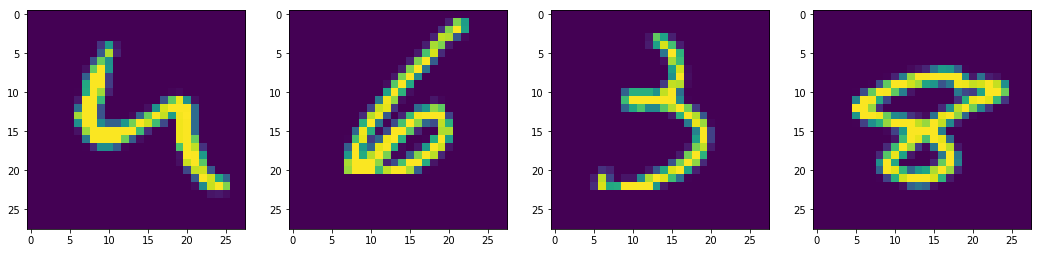

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from models.MNISTNet import MNISTNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from utils.datasets import MNIST
import numpy as np

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [2]:
from nn.optimizers import RMSprop

model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.0001, decay=0,  sheduler_func=func, bias_correction=True)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)

import time
start = time.time()
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=30, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=-1, test_intervals=500, print_intervals=100)
print('cost:', time.time()-start)

Epoch 0: 
Train iter 100/1600:	acc 0.10, loss 2.30, reg loss 0.00, speed 1178.28 imgs/sec
Train iter 200/1600:	acc 0.20, loss 2.30, reg loss 0.00, speed 1188.81 imgs/sec
Train iter 300/1600:	acc 0.13, loss 2.30, reg loss 0.00, speed 1193.99 imgs/sec
Train iter 400/1600:	acc 0.17, loss 2.30, reg loss 0.00, speed 1213.00 imgs/sec
Test acc 0.11, loss 2.30
Train iter 500/1600:	acc 0.07, loss 2.30, reg loss 0.00, speed 471.32 imgs/sec
Train iter 600/1600:	acc 0.17, loss 2.29, reg loss 0.00, speed 1203.46 imgs/sec
Train iter 700/1600:	acc 0.33, loss 2.20, reg loss 0.00, speed 1201.99 imgs/sec
Train iter 800/1600:	acc 0.30, loss 2.04, reg loss 0.00, speed 1158.76 imgs/sec
Train iter 900/1600:	acc 0.43, loss 1.79, reg loss 0.01, speed 1172.44 imgs/sec
Test acc 0.43, loss 1.69
Train iter 1000/1600:	acc 0.40, loss 1.70, reg loss 0.01, speed 476.31 imgs/sec
Train iter 1100/1600:	acc 0.33, loss 1.85, reg loss 0.01, speed 1148.88 imgs/sec


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

# Train your best MNISTNet!
Tweak the hyperparameters and structure of the MNISTNet. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

In [ ]:
# define your new model and all training codes here, like loading data, defining optimizer and so on

# ...


## Your Description and Analysis
Please write down what you have tuned for your best MNISTNet. And please write down your analysis about their impacts on performance.

-----------------------------------

write here (remove it before writing your description and analysis)

-----------------------------------

# Marking Scheme

Marking scheme is shown below:
- 4 marks for `Adam` update function
- 5 marks for `conv` forward and backward function
- 4 marks for `pool` forward and backward function
- 3 marks for `dropout` forward and backward function
- 3 marks for tuning your best MNISTNet
- 1 marks for your submission format

We will run multiple test cases to check the correctness of the implementation for `Adam`, `conv`, `pool`, `dropout`. As for submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github. We have offered all materials that you can refer to in this notebook.

# Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 

**ASSIGNMENT DEADLINE: 4 Mar 2019 (MON) 17:00**

Do not include the `data` folder as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment 1 Submission. If unzip the file, the structure should be like this:

```bash
e0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```